In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dark2 = sns.color_palette('Dark2')

from scipy import stats
import shap

from feature import feature_selection_by_corr, feature_selection_by_infogain
from model import compute_eval_metric

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.model_selection import RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from yellowbrick.regressor import PredictionError,ResidualsPlot

plt.style.use("dark_background")
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

c:\Users\sfg\Anaconda3\envs\mpg_bbyield\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_bby = pd.read_csv('../data/WildBlueberryPollinationSimulationData.csv')
df_bby.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [3]:
df_bby.shape

(777, 18)

In [4]:
df_bby.isna().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

In [5]:
df_bby.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,388.000000,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,224.444871,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,194.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,388.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,582.000000,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [6]:
df_bby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [7]:
df_bby.nunique()

Row#                    777
clonesize                 6
honeybee                  7
bumbles                  10
andrena                  12
osmia                    12
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MaxOfLowerTRange          5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
fruitset                777
fruitmass               777
seeds                   777
yield                   777
dtype: int64

In [8]:
df_yield = df_bby.drop(columns=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee', "fruitset", "fruitmass", "seeds"])
df_yield.head()


,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.25,0.25,0.25,71.9,50.8,0.26,3813.165795
1,37.5,0.25,0.25,0.25,71.9,50.8,0.10,4947.605663
2,37.5,0.25,0.25,0.25,79.0,55.9,0.26,3866.798965
3,37.5,0.25,0.25,0.25,79.0,55.9,0.10,4303.943030
4,37.5,0.25,0.25,0.25,71.9,50.8,0.39,3436.493543


#### Z-score

In [9]:
zscore = np.abs(stats.zscore(df_yield))
print(zscore)

     clonesize   bumbles   andrena     osmia  AverageOfUpperTRange  \
0     2.678126  0.488512  1.359549  1.846405              0.414096   
1     2.678126  0.488512  1.359549  1.846405              0.414096   
2     2.678126  0.488512  1.359549  1.846405              1.339534   
3     2.678126  0.488512  1.359549  1.846405              1.339534   
4     2.678126  0.488512  1.359549  1.846405              0.414096   
..         ...       ...       ...       ...                   ...   
772   1.253503  2.494523  0.371655  2.982429              0.414096   
773   3.035546  2.494523  0.371655  2.982429              0.414096   
774   0.176180  2.494523  0.371655  2.982429              0.414096   
775   0.176180  2.494523  0.371655  2.982429              0.407067   
776   0.176180  2.494523  0.371655  2.982429              0.407067   

     AverageOfLowerTRange  AverageRainingDays     yield  
0                0.403960            0.350531  1.622087  
1                0.403960            1.2852

In [10]:
df_yield_zscore = df_yield[(zscore < 3).all(axis=1)]
df_yield_zscore.shape

(767, 8)

c:\Users\sfg\Anaconda3\envs\mpg_bbyield\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


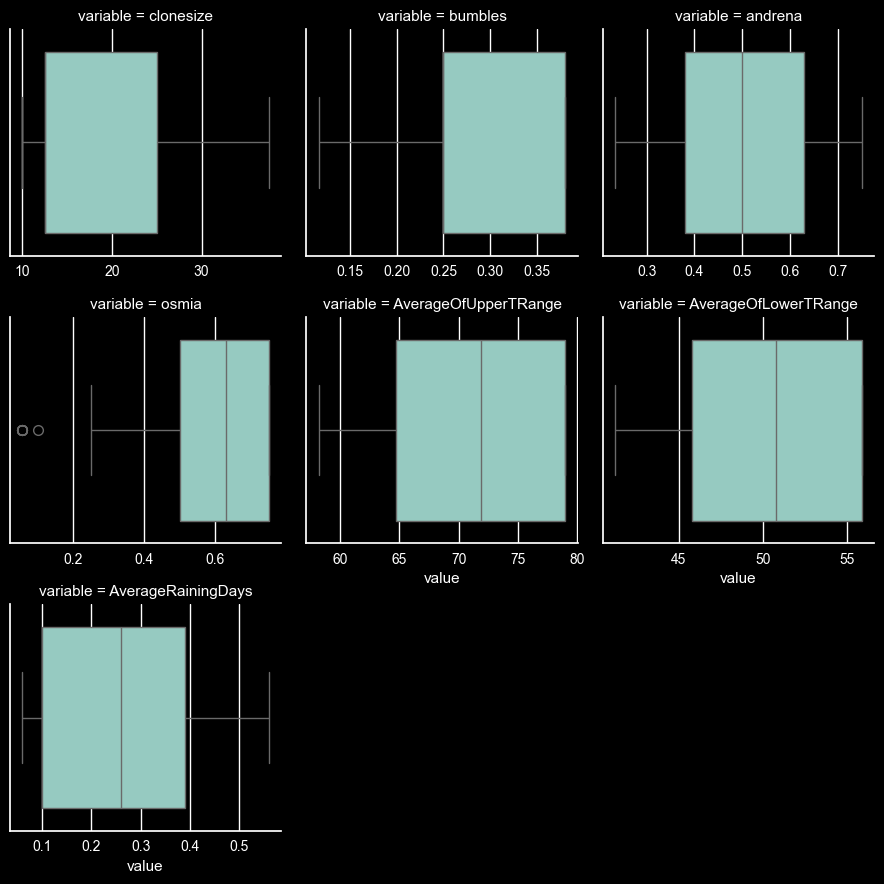

In [11]:
unpivot_zscore = pd.melt(df_yield_zscore, df_yield_zscore.columns[-1], df_yield_zscore.columns[:-1])

g = sns.FacetGrid(unpivot_zscore, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")
plt.show()

#### Traning the model on data where outlier were removed based on Z-score

In [12]:
df_yield_main = df_yield_zscore

In [13]:
# Split the data
X = df_yield_main.drop(['yield'], axis=1)
y = df_yield_main['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#### Using Information Gain to select features

In [14]:
# select top 7 features
X_train_fs, X_test_fs, fs_info = feature_selection_by_infogain(X_train, y_train, X_test, x=7)

### Fitting Models

#### Linear Regression

In [15]:
lr = LinearRegression()
lr.fit(X_train_fs, y_train)
y_pred_lr = lr.predict(X_test_fs)

mae_lr, mse_lr, rmse_lr, rsq_lr = compute_eval_metric(y_test, y_pred_lr)

print('Linear Regression')
print('-' * 20)
print('MAE: %.2f' % mae_lr)
print('MSE: %.2f' % mse_lr)
print('RMSE: %.2f' % rmse_lr)
print('R-Squared: %.2f' % rsq_lr)

Linear Regression
--------------------
MAE: 498.59
MSE: 362441.79
RMSE: 602.03
R-Squared: 0.80


#### Random Forest Regressor

In [16]:
rf = RandomForestRegressor()
rf.fit(X_train_fs, y_train)
y_pred_rf = rf.predict(X_test_fs)

mae_rf, mse_rf, rmse_rf, rsq_rf = compute_eval_metric(y_test, y_pred_rf)

print('Random Forest Regressor')
print('-' * 25)
print('MAE: %.2f' % mae_rf)
print('MSE: %.2f' % mse_rf)
print('RMSE: %.2f' % rmse_rf)
print('R-Squared: %.2f' % rsq_rf)

Random Forest Regressor
-------------------------
MAE: 211.90
MSE: 76097.84
RMSE: 275.86
R-Squared: 0.96


#### Decision Tree Regressor

In [17]:
dt = DecisionTreeRegressor()
dt.fit(X_train_fs, y_train)
y_pred_dt = dt.predict(X_test_fs)

mae_dt, mse_dt, rmse_dt, rsq_dt = compute_eval_metric(y_test, y_pred_dt)

print('Decision Tree Regressor')
print('-' * 25)
print('MAE: %.2f' % mae_dt)
print('MSE: %.2f' % mse_dt)
print('RMSE: %.2f' % rmse_dt)
print('R-Squared: %.2f' % rsq_dt)

Decision Tree Regressor
-------------------------
MAE: 260.77
MSE: 116042.00
RMSE: 340.65
R-Squared: 0.94


#### XGBRegressor

In [18]:
xgb = XGBRegressor()
xgb.fit(X_train_fs, y_train)
y_pred_xgb = xgb.predict(X_test_fs)

mae_xgb, mse_xgb, rmse_xgb, rsq_xgb = compute_eval_metric(y_test, y_pred_xgb)

print('XGB Regressor')
print('-' * 20)
print('MAE: %.2f' % mae_xgb)
print('MSE: %.2f' % mse_xgb)
print('RMSE: %.2f' % rmse_xgb)
print('R-Squared: %.2f' % rsq_xgb)

XGB Regressor
--------------------
MAE: 177.24
MSE: 60308.16
RMSE: 245.58
R-Squared: 0.97


#### Plotting Evaluation Metric

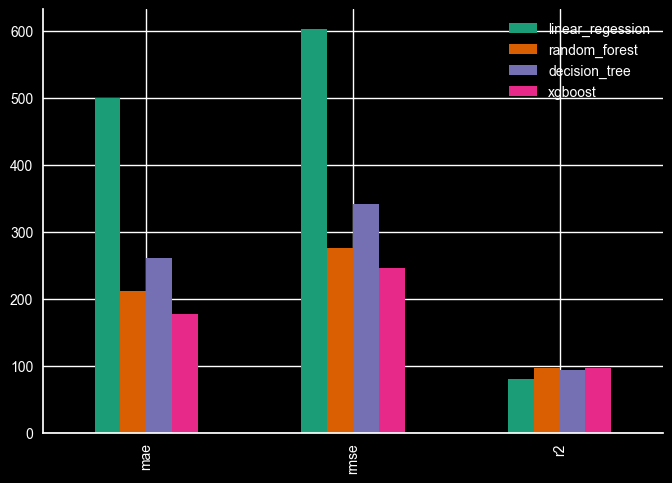

In [19]:
dict_eval = {
    "linear_regession":{
        "mae": mae_lr,
        "rmse": rmse_lr,
        "r2": rsq_lr * 100
    },
    "random_forest":{
        "mae": mae_rf,
        "rmse": rmse_rf,
        "r2": rsq_rf * 100
    },
    "decision_tree":{
        "mae": mae_dt,
        "rmse": rmse_dt,
        "r2": rsq_dt * 100
    },
    "xgboost":{
        "mae": mae_xgb,
        "rmse": rmse_xgb,
        "r2": rsq_xgb * 100
    }
}

df_eval = pd.DataFrame(dict_eval)
df_eval.plot(kind='bar', color=[dark2[0], dark2[1], dark2[2], dark2[3]])
plt.show()

#### Hyperparameter Tuning

In [20]:
cv = RepeatedKFold(n_splits= 50, n_repeats = 3)
fs_mir_v0 = SelectKBest(score_func=mutual_info_regression)

In [21]:
# create pipelines for various models
pipe_lr = Pipeline([
    ('sel', fs_mir_v0),
    ('model', LinearRegression())
])

pipe_rf = Pipeline([
    ('sel', fs_mir_v0),
    ('model', RandomForestRegressor(random_state=1))
])

pipe_dt = Pipeline([
    ('sel', fs_mir_v0),
    ('model', DecisionTreeRegressor(random_state=1))
])

pipe_xgb = Pipeline([
    ('sel', fs_mir_v0),
    ('model', XGBRegressor(random_state=1))
])

In [22]:
# grid params
grid_params_lr = [{'sel__k':[1,2]}]

grid_params_rf = [{'sel__k':[1,2],
                   'model__max_depth': [15, 18, 10],
                   'model__min_samples_split': [15, 18, 10]
                   }]

grid_params_dt = [{'sel__k':[1,2],
                   'model__max_depth': [15, 18, 10],
                   'model__max_features': ['log2', 'sqrt', None]
                   }]

grid_params_xgb = [{'sel__k':[1,2],
                   'model__max_depth': [9, 12],
                   'model__min_child_weight': [7, 8],
                   'model__subsample': [i/10 for i in range(9, 11)]
                    }]

In [23]:
grid_search_lr = GridSearchCV(estimator=pipe_lr,
                              param_grid=grid_params_lr,
                              scoring='neg_mean_absolute_error',
                              cv=cv)

grid_search_rf = GridSearchCV(estimator=pipe_rf,
                              param_grid=grid_params_rf,
                              scoring='neg_mean_absolute_error',
                              cv=cv,
                              n_jobs=-1)

grid_search_dt = GridSearchCV(estimator=pipe_dt,
                              param_grid=grid_params_dt,
                              scoring='neg_mean_absolute_error',
                              cv=cv,
                              n_jobs=-1)

grid_search_xgb = GridSearchCV(estimator=pipe_xgb,
                              param_grid=grid_params_xgb,
                              scoring='neg_mean_absolute_error',
                              cv=cv,
                              n_jobs=-1)


lst_gs = [grid_search_lr, grid_search_rf, grid_search_dt, grid_search_xgb]

dict_gs = {0: 'Linear Regression',
           1: 'Random Forest',
           2: 'Decision Tree',
           3: 'XGBoost'}

In [24]:
def extract_best_model(lst_gs: list, dict_gs: dict):
    print('Performing model optimizations...')
    least_mae = 270817
    best_regr = 0
    best_gs = ''
    
    for idx, gs in enumerate(lst_gs):
        print('\nEstimator: %s' % dict_gs[idx])
        gs.fit(X_train_fs, y_train)

        print('Best Config: %s' % gs.best_params_)
        print('Best MAE: %.3f' % gs.best_score_)
        
        y_pred_v0 = gs.predict(X_test_fs)
        curr_mae = mean_absolute_error(y_test, y_pred_v0)
        curr_mse = mean_squared_error(y_test, y_pred_v0)

        print('MAE on test set for best params: %.3f ' % curr_mae)
        print('RMSE on test set for best params: %.3f ' % np.sqrt(curr_mse))
        
        if curr_mae < least_mae:
            least_mae = curr_mae
            best_gs = gs
            best_regr = idx

    print('\nClassifier with least test set MAE: %s' % dict_gs[best_regr])
    return (dict_gs[best_regr], best_gs, least_mae)

In [25]:
best_model_name_v0, best_model_v0, least_mae_v0 = extract_best_model(lst_gs = lst_gs, dict_gs = dict_gs)
print(f"Best Model: {best_model_name_v0}")
print(f"Error Rate: {least_mae_v0}")
print(best_model_v0)

Performing model optimizations...

Estimator: Linear Regression
Best Config: {'sel__k': 2}
Best MAE: -643.299
MAE on test set for best params: 691.125 
RMSE on test set for best params: 864.894 

Estimator: Random Forest
Best Config: {'model__max_depth': 15, 'model__min_samples_split': 15, 'sel__k': 2}
Best MAE: -619.357
MAE on test set for best params: 649.424 
RMSE on test set for best params: 810.341 

Estimator: Decision Tree
Best Config: {'model__max_depth': 15, 'model__max_features': 'log2', 'sel__k': 2}
Best MAE: -612.405
MAE on test set for best params: 649.649 
RMSE on test set for best params: 813.306 

Estimator: XGBoost
Best Config: {'model__max_depth': 9, 'model__min_child_weight': 8, 'model__subsample': 0.9, 'sel__k': 2}
Best MAE: -617.862
MAE on test set for best params: 646.391 
RMSE on test set for best params: 810.095 

Classifier with least test set MAE: XGBoost
Best Model: XGBoost
Error Rate: 646.3910527822342
GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=50, 

XGBoost performed the best out of all the models. But since the performance of Random Forest was only slightly less than XGBoost and the that it is a simple model, we can further finetune Random Forest.

In [26]:
n_features = X_train_fs.shape[1]
fs_mir_v1 = SelectKBest(score_func=mutual_info_regression, k=7)

pipe_rf_v1 = Pipeline([
    ('sel', fs_mir_v0),
    ('model', RandomForestRegressor(random_state=1, criterion='squared_error'))
])

grid_params_rf_v1 = [{'sel__k':[1, n_features],
                      'model__max_depth': [15, 18, 10],
                      'model__min_samples_split': [2, 5]
                   }]

grid_search_rf_v1 = GridSearchCV(estimator=pipe_rf_v1,
                              param_grid=grid_params_rf_v1,
                              scoring='neg_mean_absolute_error',
                              cv=cv,
                              n_jobs=-1)


print("Random Forest v1 optimising...")
grid_search_rf_v1.fit(X_train_fs, y_train)
print('Best Config: %s' % grid_search_rf_v1.best_params_)
print('Best MAE: %.3f' % grid_search_rf_v1.best_score_)
y_pred_rf_v1 = grid_search_rf_v1.predict(X_test_fs)
print('MAE on test set for best params: %.3f ' % mean_absolute_error(y_test, y_pred_rf_v1))
print('RMSE on test set for best params: %.3f ' % np.sqrt(mean_squared_error(y_test, y_pred_rf_v1)))

Random Forest v1 optimising...
Best Config: {'model__max_depth': 15, 'model__min_samples_split': 2, 'sel__k': 7}
Best MAE: -213.386
MAE on test set for best params: 207.801 
RMSE on test set for best params: 270.036 


#### Visualization - Model Prediction Error

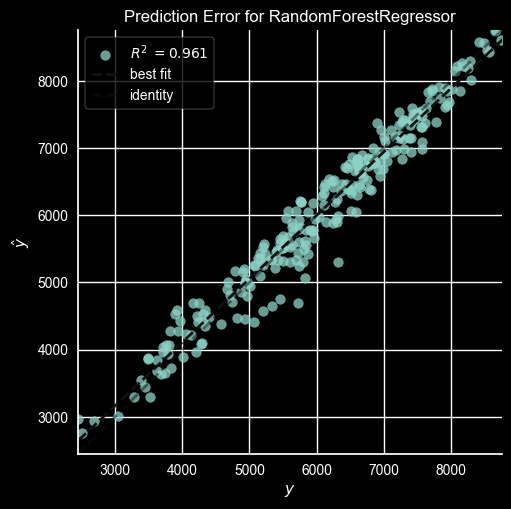

In [27]:
best_param_model = grid_search_rf_v1.best_estimator_
visualizer = PredictionError(best_param_model)
visualizer.fit(X_train_fs, y_train)
visualizer.score(X_test_fs, y_test)
visualizer.show()
plt.show()

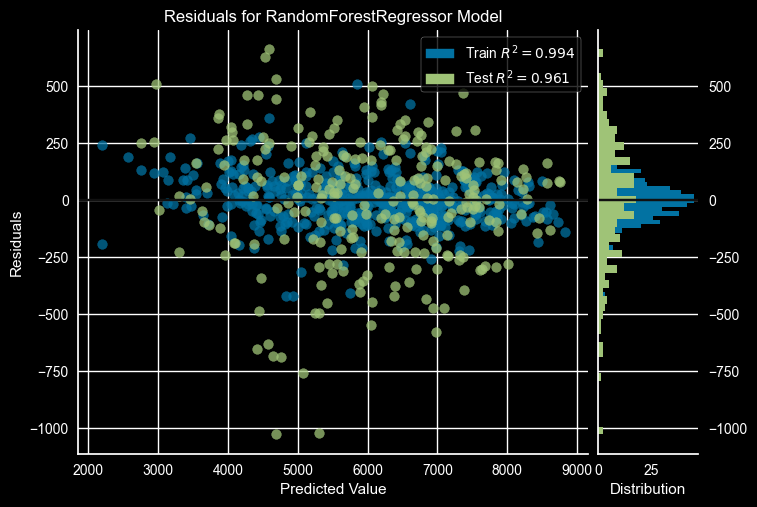

In [28]:
visualizer = ResidualsPlot(best_param_model)
visualizer.fit(X_train_fs, y_train)
visualizer.score(X_test_fs, y_test)
visualizer.show()  
plt.show()

Now let us train the Random Forest with the best parameters

In [29]:
fs_rf = SelectKBest(score_func=mutual_info_regression, k=7)
fs_rf.fit(X_train, y_train)
X_train_rf = fs_rf.transform(X_train)
X_test_rf = fs_rf.transform(X_test)
rf_final = RandomForestRegressor(max_depth=15, min_samples_split=2, criterion='squared_error')

rf_final.fit(X_train_rf, y_train)
y_pred_rf_final = rf_final.predict(X_test_rf)

print('\nRaandom Forest Final Model')
print('-' * 25)
print('MAE:', mean_absolute_error(y_test, y_pred_rf_final))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf_final)))


Raandom Forest Final Model
-------------------------
MAE: 211.75377477476417
RMSE: 271.53322176261884
